# Autocorrelation Function (ACF) Estimation: Comparative Study

This notebook compares four ACF estimation methods using a signal that mixes deterministic and random components:

$$
x[n] = A\cos\left(2\pi f_0\frac{n}{f_s} + \phi_0\right) + w[n],\quad w[n]\sim\mathcal{N}(0,\sigma_w^2)
$$

For this model (random phase interpretation), the reference ACF is:

$$
R_x[k] = \frac{A^2}{2}\cos\left(2\pi f_0\frac{k}{f_s}\right) + \sigma_w^2\,\delta[k]
$$

Methods under comparison:

1. Direct method (biased and unbiased).
2. FFT-based method.
3. Parametric AR(p) method (Yule-Walker).
4. Recursive method (EWMA).

The comparison includes:

- Experimental runtime measurements.
- Theoretical computational complexity.
- Sensitivity to sample size.
- Practical advantages and disadvantages.

In [1]:
from __future__ import annotations

import time
from typing import Callable, Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn-v0_8-whitegrid")
np.set_printoptions(precision=4, suppress=True)

## Method Implementations

In [2]:
def generate_cosine_plus_noise(
    n_samples: int,                  # Number of samples in the signal
    sample_rate_hz: float,           # Sampling frequency [Hz]
    cosine_freq_hz: float,           # Cosine frequency [Hz]
    cosine_amplitude: float,         # Cosine amplitude
    noise_std: float,                # White-noise standard deviation
    rng: np.random.Generator,        # Random generator for reproducibility
    phase_rad: float = 0.0,          # Initial cosine phase [rad]
) -> np.ndarray:                     # Signal x[n] = cosine + Gaussian noise
    """Generate a deterministic cosine contaminated with white Gaussian noise.

    Purpose:
        Create a controlled test signal with known deterministic and stochastic components.

    Parameters:
        n_samples: Number of generated samples.
        sample_rate_hz: Sampling frequency in hertz.
        cosine_freq_hz: Frequency of the deterministic cosine in hertz.
        cosine_amplitude: Amplitude of the deterministic cosine.
        noise_std: Standard deviation of the additive white Gaussian noise.
        rng: Pseudo-random number generator.
        phase_rad: Cosine initial phase in radians.

    Returns:
        A one-dimensional numpy array with shape (n_samples,).

    Side effects:
        Advances the state of `rng`.
    """
    if n_samples < 2:
        raise ValueError("n_samples must be >= 2.")
    if sample_rate_hz <= 0.0:
        raise ValueError("sample_rate_hz must be positive.")

    # Build deterministic cosine component using explicit time samples [s].
    n = np.arange(n_samples, dtype=float)
    time_s = n / sample_rate_hz
    deterministic = cosine_amplitude * np.cos(2.0 * np.pi * cosine_freq_hz * time_s + phase_rad)

    # Add zero-mean Gaussian white noise.
    stochastic = noise_std * rng.standard_normal(n_samples)
    return deterministic + stochastic


def _two_sided_from_positive_lags(
    acf_pos: np.ndarray,             # ACF values for non-negative lags [0..L]
) -> Tuple[np.ndarray, np.ndarray]:  # (lags from -L..L, symmetric ACF)
    """Create the two-sided ACF using even symmetry for real-valued processes."""
    max_lag = int(acf_pos.size - 1)
    lags = np.arange(-max_lag, max_lag + 1)
    acf_two_sided = np.concatenate((acf_pos[:0:-1], acf_pos))
    return lags, acf_two_sided


def theoretical_acf_cosine_noise(
    max_lag: int,                    # Maximum non-negative lag L
    cosine_amplitude: float,         # Cosine amplitude A
    cosine_freq_hz: float,           # Cosine frequency f0 [Hz]
    sample_rate_hz: float,           # Sampling frequency fs [Hz]
    noise_std: float,                # Noise standard deviation sigma_w
) -> Tuple[np.ndarray, np.ndarray]:  # Theoretical two-sided ACF
    """Return the theoretical ACF for cosine plus white Gaussian noise.

    Purpose:
        Provide a reference ACF to evaluate estimation error across methods.

    Parameters:
        max_lag: Maximum lag L for the returned window [-L, L].
        cosine_amplitude: Cosine amplitude A.
        cosine_freq_hz: Cosine frequency f0 in hertz.
        sample_rate_hz: Sampling frequency fs in hertz.
        noise_std: White-noise standard deviation sigma_w.

    Returns:
        Tuple `(lags, acf)` with lags in [-L, L] and the corresponding
        theoretical autocorrelation values.

    Side effects:
        None.
    """
    if max_lag < 0:
        raise ValueError("max_lag must be non-negative.")

    # Compute the deterministic cosine contribution for non-negative lags.
    lags_pos = np.arange(max_lag + 1, dtype=float)
    acf_pos = (cosine_amplitude**2 / 2.0) * np.cos(2.0 * np.pi * cosine_freq_hz * lags_pos / sample_rate_hz)

    # Add the white-noise impulse contribution at lag zero.
    acf_pos[0] += noise_std**2
    return _two_sided_from_positive_lags(acf_pos)


def acf_direct(
    signal: np.ndarray,              # Input signal x[n]
    max_lag: int,                    # Maximum non-negative lag L
    unbiased: bool = False,          # If True uses 1/(N-k), else 1/N
) -> Tuple[np.ndarray, np.ndarray]:  # Two-sided direct ACF estimate
    """Estimate the ACF directly in the time domain.

    Purpose:
        Compute direct sample autocorrelation as baseline estimators.

    Parameters:
        signal: Real-valued input sequence.
        max_lag: Maximum lag L of interest.
        unbiased: Select unbiased normalization (True) or biased normalization (False).

    Returns:
        Tuple `(lags, acf)` for lags in [-L, L].

    Side effects:
        None.
    """
    n_samples = int(signal.size)
    if n_samples < 2:
        raise ValueError("signal must contain at least two samples.")
    if max_lag < 0:
        raise ValueError("max_lag must be non-negative.")

    max_lag = min(max_lag, n_samples - 1)

    # Compute raw sums S[k] = sum x[n]x[n+k] for k = 0..L.
    raw_sums = np.empty(max_lag + 1, dtype=float)
    for lag in range(max_lag + 1):
        raw_sums[lag] = float(np.dot(signal[: n_samples - lag], signal[lag:]))

    # Apply selected normalization for biased or unbiased estimate.
    if unbiased:
        denominator = n_samples - np.arange(max_lag + 1)
    else:
        denominator = np.full(max_lag + 1, n_samples, dtype=float)

    acf_pos = raw_sums / denominator
    return _two_sided_from_positive_lags(acf_pos)


def acf_fft_biased(
    signal: np.ndarray,              # Input signal x[n]
    max_lag: int,                    # Maximum non-negative lag L
) -> Tuple[np.ndarray, np.ndarray]:  # Two-sided FFT-based ACF estimate
    """Estimate the biased ACF using FFT with zero-padding.

    Purpose:
        Accelerate autocorrelation estimation by leveraging convolution in the
        frequency domain.

    Parameters:
        signal: Real-valued input sequence.
        max_lag: Maximum lag L of interest.

    Returns:
        Tuple `(lags, acf)` for lags in [-L, L] with biased normalization.

    Side effects:
        None.
    """
    n_samples = int(signal.size)
    if n_samples < 2:
        raise ValueError("signal must contain at least two samples.")
    if max_lag < 0:
        raise ValueError("max_lag must be non-negative.")

    max_lag = min(max_lag, n_samples - 1)

    # Zero-pad to avoid circular wrap-around in the aperiodic correlation region.
    fft_len = 1 << int(np.ceil(np.log2(2 * n_samples)))
    signal_padded = np.zeros(fft_len, dtype=float)
    signal_padded[:n_samples] = signal

    # Obtain correlation sums via inverse FFT of the power spectrum.
    spectrum = np.fft.fft(signal_padded)
    raw_corr = np.fft.ifft(np.abs(spectrum) ** 2).real[: max_lag + 1]

    # Match biased normalization used in the direct biased estimator.
    acf_pos = raw_corr / n_samples
    return _two_sided_from_positive_lags(acf_pos)


def acf_ar_yule_walker(
    signal: np.ndarray,              # Input signal x[n]
    max_lag: int,                    # Maximum non-negative lag L
    ar_order: int,                   # AR model order p
) -> Tuple[np.ndarray, np.ndarray, Dict[str, np.ndarray | float]]:  # ACF and AR model metadata
    """Estimate ACF by fitting an AR(p) model with Yule-Walker equations.

    Purpose:
        Obtain a smooth parametric ACF estimate using a compact AR model.

    Parameters:
        signal: Real-valued input sequence.
        max_lag: Maximum lag L of interest.
        ar_order: AR order p for the parametric model.

    Returns:
        Tuple `(lags, acf, model_info)` where `model_info` includes AR
        coefficients and innovation variance.

    Side effects:
        None.

    Assumptions:
        The process can be reasonably approximated by an AR model of order p.
    """
    n_samples = int(signal.size)
    if n_samples < 3:
        raise ValueError("signal must contain at least three samples.")
    if max_lag < 1:
        raise ValueError("max_lag must be at least 1.")

    max_lag = min(max_lag, n_samples - 1)
    ar_order = min(ar_order, max_lag, n_samples - 1)
    if ar_order < 1:
        raise ValueError("ar_order must be at least 1 after clipping.")

    # Estimate biased sample ACF terms required by Yule-Walker.
    acf_head_sample = np.empty(ar_order + 1, dtype=float)
    for lag in range(ar_order + 1):
        acf_head_sample[lag] = float(np.dot(signal[: n_samples - lag], signal[lag:]) / n_samples)

    # Solve Toeplitz Yule-Walker equations for AR coefficients.
    lag_indices = np.abs(np.subtract.outer(np.arange(ar_order), np.arange(ar_order)))
    toeplitz_matrix = acf_head_sample[lag_indices]
    rhs = acf_head_sample[1 : ar_order + 1]
    regularization = 1e-10 * np.eye(ar_order)
    ar_coeffs = np.linalg.solve(toeplitz_matrix + regularization, rhs)

    # Estimate innovation variance from the zero-lag Yule-Walker relation.
    innovation_variance = float(acf_head_sample[0] - np.dot(ar_coeffs, acf_head_sample[1 : ar_order + 1]))
    innovation_variance = max(innovation_variance, 1e-12)

    # Recover R[0..p] from AR consistency equations before recursion.
    head_matrix = np.zeros((ar_order + 1, ar_order + 1), dtype=float)
    head_rhs = np.zeros(ar_order + 1, dtype=float)
    head_matrix[0, 0] = 1.0
    head_matrix[0, 1:] = -ar_coeffs
    head_rhs[0] = innovation_variance

    for lag in range(1, ar_order + 1):
        head_matrix[lag, lag] = 1.0
        for coeff_idx, coeff in enumerate(ar_coeffs, start=1):
            head_matrix[lag, abs(lag - coeff_idx)] -= coeff

    acf_head_model = np.linalg.solve(head_matrix + 1e-10 * np.eye(ar_order + 1), head_rhs)

    # Extend the parametric ACF to the desired lag range.
    acf_pos = np.zeros(max_lag + 1, dtype=float)
    acf_pos[: ar_order + 1] = acf_head_model
    for lag in range(ar_order + 1, max_lag + 1):
        past_values = acf_pos[lag - ar_order : lag][::-1]
        acf_pos[lag] = float(np.dot(ar_coeffs, past_values))

    lags, acf = _two_sided_from_positive_lags(acf_pos)
    model_info = {
        "coefficients": ar_coeffs,
        "innovation_variance": innovation_variance,
    }
    return lags, acf, model_info


def acf_recursive_ewma(
    signal: np.ndarray,                # Input signal x[n]
    max_lag: int,                      # Maximum non-negative lag L
    forgetting_factor: float = 0.995, # EWMA forgetting factor lambda
) -> Tuple[np.ndarray, np.ndarray]:    # Two-sided EWMA ACF estimate
    """Estimate ACF recursively using an EWMA update.

    Purpose:
        Provide an online estimator that updates correlation values sample by sample.

    Parameters:
        signal: Real-valued input sequence.
        max_lag: Maximum lag L of interest.
        forgetting_factor: EWMA forgetting factor λ in (0, 1).

    Returns:
        Tuple `(lags, acf)` for lags in [-L, L].

    Side effects:
        None.

    Assumptions:
        A single fixed λ is used for all lags and all time instants.
    """
    n_samples = int(signal.size)
    if n_samples < 2:
        raise ValueError("signal must contain at least two samples.")
    if max_lag < 0:
        raise ValueError("max_lag must be non-negative.")
    if not (0.0 < forgetting_factor < 1.0):
        raise ValueError("forgetting_factor must be in (0, 1).")

    max_lag = min(max_lag, n_samples - 1)
    acf_pos = np.zeros(max_lag + 1, dtype=float)

    # Process samples sequentially as in a streaming scenario.
    for n_idx in range(n_samples):
        x_n = signal[n_idx]

        # Update lag-0 correlation term (instantaneous power).
        acf_pos[0] = forgetting_factor * acf_pos[0] + (1.0 - forgetting_factor) * (x_n * x_n)

        # Update higher lags only when past samples are available.
        lag_limit = min(max_lag, n_idx)
        for lag in range(1, lag_limit + 1):
            product = x_n * signal[n_idx - lag]
            acf_pos[lag] = forgetting_factor * acf_pos[lag] + (1.0 - forgetting_factor) * product

    return _two_sided_from_positive_lags(acf_pos)


def benchmark_runtime_ms(
    estimator: Callable[[np.ndarray, int], object],  # Estimator function to benchmark
    signal: np.ndarray,                               # Input signal for the benchmark
    max_lag: int,                                     # Maximum lag used by the estimator
    n_repetitions: int = 5,                           # Number of timing repetitions
) -> float:                                           # Median runtime [ms]
    """Measure median estimator runtime in milliseconds.

    Purpose:
        Provide a stable experimental runtime metric for cross-method comparison.

    Parameters:
        estimator: Callable receiving `(signal, max_lag)`.
        signal: Input signal used in the timing experiment.
        max_lag: Lag window passed to the estimator.
        n_repetitions: Number of timing runs after a warm-up call.

    Returns:
        Median runtime in milliseconds.

    Side effects:
        Executes the estimator repeatedly.
    """
    if n_repetitions < 1:
        raise ValueError("n_repetitions must be >= 1.")

    # Warm-up run to reduce one-time overhead impact.
    estimator(signal, max_lag)

    durations_ms = []
    for _ in range(n_repetitions):
        start_s = time.perf_counter()
        estimator(signal, max_lag)
        elapsed_ms = (time.perf_counter() - start_s) * 1e3
        durations_ms.append(elapsed_ms)

    return float(np.median(durations_ms))

## Single-Realization ACF Comparison

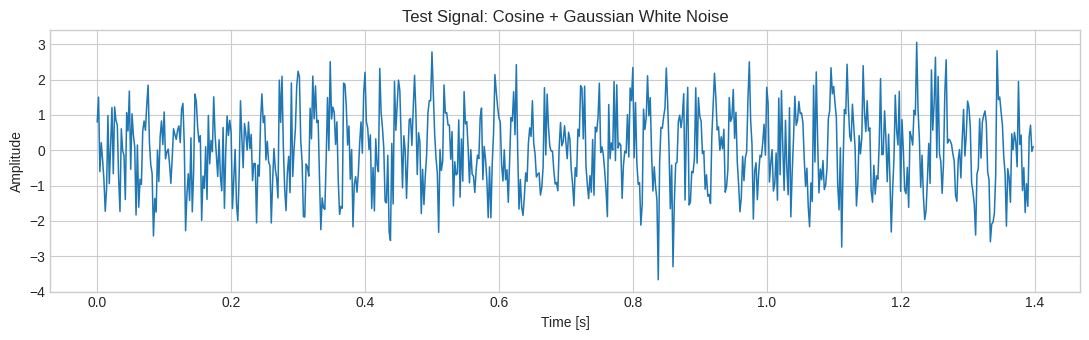

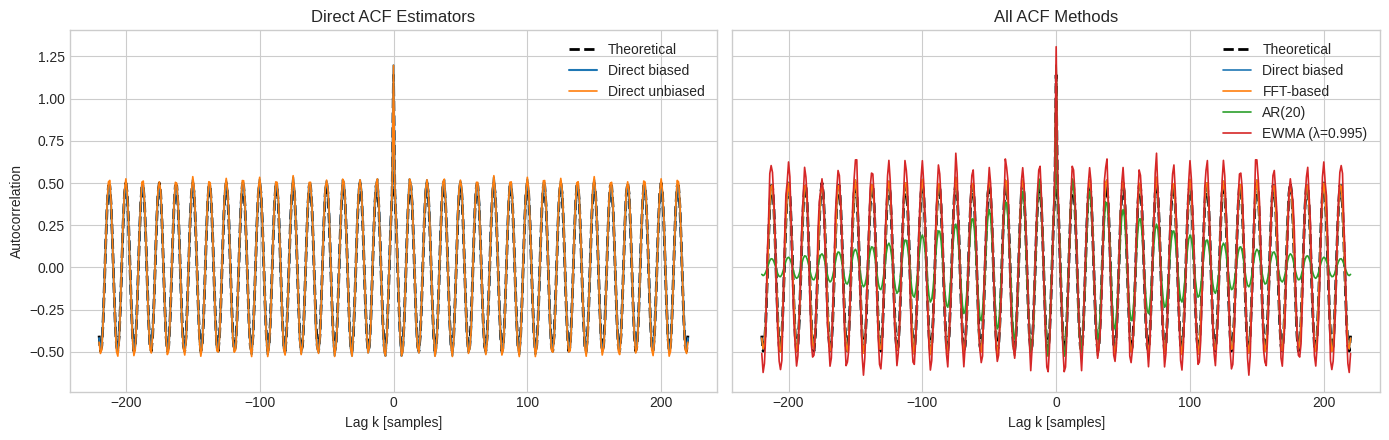

Estimated AR order: 20
Estimated innovation variance: 0.735014
First 6 AR coefficients: [ 0.0795  0.0421  0.0074 -0.0027 -0.0718 -0.1014]


In [3]:
# Signal configuration for the qualitative ACF shape comparison.
sample_rate_hz = 500.0
cosine_freq_hz = 40.0
cosine_amplitude = 1.0
noise_std = 0.8
phase_rad = 0.4

n_samples = 4096
max_lag_display = 220
ar_order = 20
forgetting_factor = 0.995

rng = np.random.default_rng(20260218)
signal = generate_cosine_plus_noise(
    n_samples=n_samples,
    sample_rate_hz=sample_rate_hz,
    cosine_freq_hz=cosine_freq_hz,
    cosine_amplitude=cosine_amplitude,
    noise_std=noise_std,
    rng=rng,
    phase_rad=phase_rad,
)

# Compute ACF estimates from all four methods.
lags_theory, acf_theory = theoretical_acf_cosine_noise(
    max_lag=max_lag_display,
    cosine_amplitude=cosine_amplitude,
    cosine_freq_hz=cosine_freq_hz,
    sample_rate_hz=sample_rate_hz,
    noise_std=noise_std,
)
lags_db, acf_direct_b = acf_direct(signal, max_lag_display, unbiased=False)
lags_du, acf_direct_u = acf_direct(signal, max_lag_display, unbiased=True)
lags_fft, acf_fft = acf_fft_biased(signal, max_lag_display)
lags_ar, acf_ar, ar_info = acf_ar_yule_walker(signal, max_lag_display, ar_order=ar_order)
lags_rec, acf_rec = acf_recursive_ewma(signal, max_lag_display, forgetting_factor=forgetting_factor)

# Plot a short segment of the input signal in time domain.
time_axis_s = np.arange(n_samples) / sample_rate_hz
view_samples = 700
plt.figure(figsize=(11, 3.5))
plt.plot(time_axis_s[:view_samples], signal[:view_samples], linewidth=1.1)
plt.title("Test Signal: Cosine + Gaussian White Noise")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# Plot direct estimators against the theoretical ACF.
fig, axes = plt.subplots(1, 2, figsize=(14, 4.5), sharey=True)

axes[0].plot(lags_theory, acf_theory, "k--", linewidth=2.0, label="Theoretical")
axes[0].plot(lags_db, acf_direct_b, linewidth=1.5, label="Direct biased")
axes[0].plot(lags_du, acf_direct_u, linewidth=1.2, label="Direct unbiased")
axes[0].set_title("Direct ACF Estimators")
axes[0].set_xlabel("Lag k [samples]")
axes[0].set_ylabel("Autocorrelation")
axes[0].legend()

# Plot all method outputs to compare shape and smoothness.
axes[1].plot(lags_theory, acf_theory, "k--", linewidth=2.0, label="Theoretical")
axes[1].plot(lags_db, acf_direct_b, linewidth=1.2, label="Direct biased")
axes[1].plot(lags_fft, acf_fft, linewidth=1.2, label="FFT-based")
axes[1].plot(lags_ar, acf_ar, linewidth=1.2, label=f"AR({ar_order})")
axes[1].plot(lags_rec, acf_rec, linewidth=1.2, label=f"EWMA (λ={forgetting_factor})")
axes[1].set_title("All ACF Methods")
axes[1].set_xlabel("Lag k [samples]")
axes[1].legend()

plt.tight_layout()
plt.show()

# Report AR model diagnostics for interpretability.
print(f"Estimated AR order: {ar_order}")
print(f"Estimated innovation variance: {ar_info['innovation_variance']:.6f}")
print("First 6 AR coefficients:", ar_info["coefficients"][:6])

## Runtime Benchmark (Experimental)

In this section, runtime is measured experimentally with `time.perf_counter`.

- Sample sizes: $N \in \{512, 1024, 2048, 4096\}$
- Full-lag benchmark: $L = N - 1$
- Metric: median runtime over repeated runs (milliseconds)

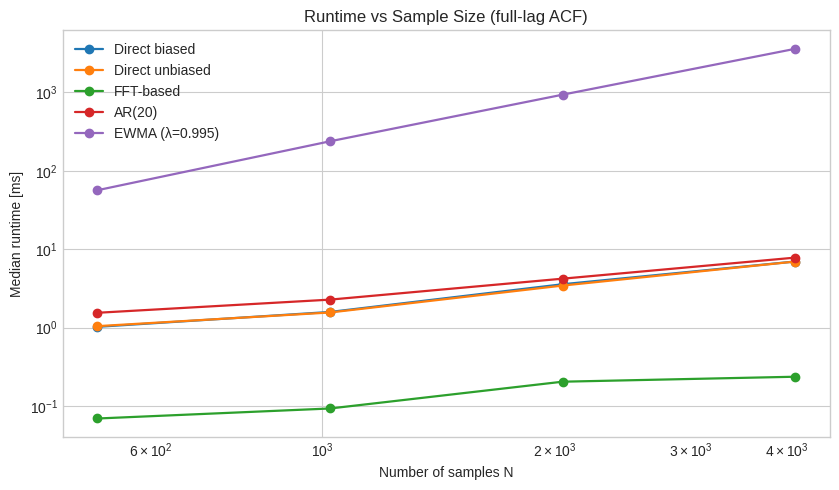

Runtime table (median ms):
N        | Direct biased        | Direct unbiased      | FFT-based            | AR(20)               | EWMA (λ=0.995)      
----------------------------------------------------------------------------------------------------------------------------------
512      |    1.023             |    1.043             |    0.069             |    1.545             |   56.588            
1024     |    1.583             |    1.559             |    0.093             |    2.274             |  238.134            
2048     |    3.573             |    3.437             |    0.204             |    4.208             |  936.436            
4096     |    6.970             |    6.959             |    0.236             |    7.812             | 3602.781            


In [4]:
sample_sizes_runtime = np.array([512, 1024, 2048, 4096], dtype=int)
n_repetitions_runtime = 4
ar_order_runtime = 20
forgetting_factor_runtime = 0.995

runtime_methods: Dict[str, Callable[[np.ndarray, int], object]] = {
    "Direct biased": lambda sig, lag: acf_direct(sig, lag, unbiased=False),
    "Direct unbiased": lambda sig, lag: acf_direct(sig, lag, unbiased=True),
    "FFT-based": acf_fft_biased,
    f"AR({ar_order_runtime})": lambda sig, lag: acf_ar_yule_walker(sig, lag, ar_order_runtime),
    f"EWMA (λ={forgetting_factor_runtime})": lambda sig, lag: acf_recursive_ewma(sig, lag, forgetting_factor_runtime),
}

runtime_ms: Dict[str, list[float]] = {name: [] for name in runtime_methods}

# Measure each method for each N with the same benchmark protocol.
for current_n in sample_sizes_runtime:
    rng_runtime = np.random.default_rng(1000 + int(current_n))
    signal_runtime = generate_cosine_plus_noise(
        n_samples=int(current_n),
        sample_rate_hz=sample_rate_hz,
        cosine_freq_hz=cosine_freq_hz,
        cosine_amplitude=cosine_amplitude,
        noise_std=noise_std,
        rng=rng_runtime,
        phase_rad=phase_rad,
    )

    full_lag = int(current_n - 1)
    for method_name, estimator in runtime_methods.items():
        elapsed_ms = benchmark_runtime_ms(
            estimator=estimator,
            signal=signal_runtime,
            max_lag=full_lag,
            n_repetitions=n_repetitions_runtime,
        )
        runtime_ms[method_name].append(elapsed_ms)

runtime_ms = {k: np.asarray(v, dtype=float) for k, v in runtime_ms.items()}

# Plot runtime growth in log-log scale to visualize complexity trends.
plt.figure(figsize=(8.5, 5.0))
for method_name, times_ms in runtime_ms.items():
    plt.loglog(sample_sizes_runtime, times_ms, marker="o", linewidth=1.6, label=method_name)

plt.title("Runtime vs Sample Size (full-lag ACF)")
plt.xlabel("Number of samples N")
plt.ylabel("Median runtime [ms]")
plt.legend()
plt.tight_layout()
plt.show()

# Print a compact runtime table for direct numerical comparison.
print("Runtime table (median ms):")
print("N".ljust(8) + " | " + " | ".join(name.ljust(20) for name in runtime_ms))
print("-" * (10 + 24 * len(runtime_ms)))
for row_idx, current_n in enumerate(sample_sizes_runtime):
    row_values = [f"{runtime_ms[name][row_idx]:8.3f}".ljust(20) for name in runtime_ms]
    print(f"{int(current_n):<8} | " + " | ".join(row_values))

## Sensitivity to Sample Size

Accuracy is evaluated with normalized RMSE (NRMSE) against the theoretical ACF on lags $0$ to $L_{eval}$:

$$
\text{NRMSE} = \frac{\sqrt{\frac{1}{L_{eval}+1}\sum_k(\hat{R}[k]-R[k])^2}}{\sqrt{\frac{1}{L_{eval}+1}\sum_k R[k]^2}}
$$

Protocol:

- $N \in \{256, 512, 1024, 2048, 4096, 8192\}$
- $L_{eval}=120$
- 8 Monte Carlo realizations per sample size
- Report median with interquartile range (IQR)

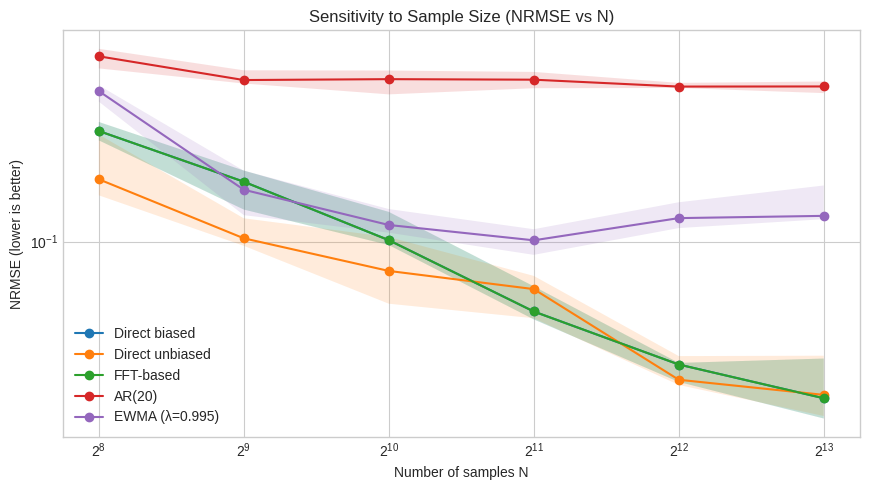

Average median NRMSE ranking (lower is better):
1. Direct unbiased      -> 0.079092
2. FFT-based            -> 0.108672
3. Direct biased        -> 0.108672
4. EWMA (λ=0.995)       -> 0.168051
5. AR(20)               -> 0.432236


In [5]:
sample_sizes_sensitivity = np.array([256, 512, 1024, 2048, 4096, 8192], dtype=int)
max_lag_eval = 120
n_realizations = 8

sensitivity_methods: Dict[str, Callable[[np.ndarray, int], object]] = {
    "Direct biased": lambda sig, lag: acf_direct(sig, lag, unbiased=False),
    "Direct unbiased": lambda sig, lag: acf_direct(sig, lag, unbiased=True),
    "FFT-based": acf_fft_biased,
    f"AR({ar_order})": lambda sig, lag: acf_ar_yule_walker(sig, lag, ar_order),
    f"EWMA (λ={forgetting_factor})": lambda sig, lag: acf_recursive_ewma(sig, lag, forgetting_factor),
}

median_nrmse: Dict[str, list[float]] = {name: [] for name in sensitivity_methods}
p25_nrmse: Dict[str, list[float]] = {name: [] for name in sensitivity_methods}
p75_nrmse: Dict[str, list[float]] = {name: [] for name in sensitivity_methods}

# Evaluate method error statistics for each sample size.
for current_n in sample_sizes_sensitivity:
    _, acf_ref = theoretical_acf_cosine_noise(
        max_lag=max_lag_eval,
        cosine_amplitude=cosine_amplitude,
        cosine_freq_hz=cosine_freq_hz,
        sample_rate_hz=sample_rate_hz,
        noise_std=noise_std,
    )
    acf_ref_pos = acf_ref[max_lag_eval:]
    ref_norm = float(np.sqrt(np.mean(acf_ref_pos**2)))

    errors_this_n: Dict[str, list[float]] = {name: [] for name in sensitivity_methods}

    for realization_idx in range(n_realizations):
        rng_sens = np.random.default_rng(50_000 + 31 * int(current_n) + realization_idx)
        signal_sens = generate_cosine_plus_noise(
            n_samples=int(current_n),
            sample_rate_hz=sample_rate_hz,
            cosine_freq_hz=cosine_freq_hz,
            cosine_amplitude=cosine_amplitude,
            noise_std=noise_std,
            rng=rng_sens,
            phase_rad=phase_rad,
        )

        for method_name, estimator in sensitivity_methods.items():
            method_output = estimator(signal_sens, max_lag_eval)
            acf_estimated = method_output[1]
            acf_est_pos = acf_estimated[max_lag_eval:]
            nrmse = float(np.sqrt(np.mean((acf_est_pos - acf_ref_pos) ** 2)) / ref_norm)
            errors_this_n[method_name].append(nrmse)

    for method_name, method_errors in errors_this_n.items():
        method_errors_np = np.asarray(method_errors, dtype=float)
        median_nrmse[method_name].append(float(np.median(method_errors_np)))
        p25_nrmse[method_name].append(float(np.percentile(method_errors_np, 25.0)))
        p75_nrmse[method_name].append(float(np.percentile(method_errors_np, 75.0)))

median_nrmse = {k: np.asarray(v, dtype=float) for k, v in median_nrmse.items()}
p25_nrmse = {k: np.asarray(v, dtype=float) for k, v in p25_nrmse.items()}
p75_nrmse = {k: np.asarray(v, dtype=float) for k, v in p75_nrmse.items()}

# Plot median NRMSE and IQR to show sensitivity to increasing N.
plt.figure(figsize=(8.8, 5.0))
for method_name in median_nrmse:
    plt.plot(sample_sizes_sensitivity, median_nrmse[method_name], marker="o", linewidth=1.5, label=method_name)
    plt.fill_between(
        sample_sizes_sensitivity,
        p25_nrmse[method_name],
        p75_nrmse[method_name],
        alpha=0.15,
    )

plt.xscale("log", base=2)
plt.yscale("log")
plt.title("Sensitivity to Sample Size (NRMSE vs N)")
plt.xlabel("Number of samples N")
plt.ylabel("NRMSE (lower is better)")
plt.legend()
plt.tight_layout()
plt.show()

# Print ranking based on average median NRMSE across all tested N.
mean_median_nrmse = {
    name: float(np.mean(values))
    for name, values in median_nrmse.items()
}
ranking = sorted(mean_median_nrmse.items(), key=lambda kv: kv[1])

print("Average median NRMSE ranking (lower is better):")
for idx, (method_name, score) in enumerate(ranking, start=1):
    print(f"{idx}. {method_name:<20} -> {score:.6f}")

## Theoretical Complexity and Qualitative Comparison

Let $N$ be the number of samples, $L$ the maximum lag estimated, and $p$ the AR order.

| Method | Time complexity for lags $0..L$ | Full-lag case $(L=N-1)$ | Memory | Sample-size sensitivity | Advantages | Disadvantages |
|---|---:|---:|---:|---|---|---|
| Direct biased | $\mathcal{O}(NL)$ | $\mathcal{O}(N^2)$ | $\mathcal{O}(L)$ | Improves with larger $N$, moderate variance | Simple, interpretable, positive-semidefinite correlation sequence | Slower than FFT for large full-lag problems; biased for $k>0$ |
| Direct unbiased | $\mathcal{O}(NL)$ | $\mathcal{O}(N^2)$ | $\mathcal{O}(L)$ | High variance at large lags, especially for small $N$ | Unbiased expectation for WSS processes | Noisy tails; may lose positive-semidefinite property |
| FFT-based (biased normalization) | $\mathcal{O}(M\log M)$, $M\approx2N$ | $\mathcal{O}(N\log N)$ | $\mathcal{O}(M)$ | Usually robust and improves with $N$ | Fastest for long full-lag ACF; mathematically equivalent to direct biased sums with zero-padding | Requires FFT setup/padding and careful normalization |
| AR(p) parametric | $\mathcal{O}(Np + p^3 + Lp)$ (naive solver) | $\mathcal{O}(Np + p^3 + Np)$ | $\mathcal{O}(p^2 + L)$ | Often good for short data if model is appropriate | Smooth low-variance ACF, compact representation | Sensitive to model order $p$ and model mismatch |
| Recursive EWMA | $\mathcal{O}(NL)$ online update | $\mathcal{O}(N^2)$ if full lags are tracked | $\mathcal{O}(L)$ | Controlled by $\lambda$: effective memory $\approx1/(1-\lambda)$ | Online/streaming, low memory, adaptive | Biased by forgetting, depends strongly on $\lambda$, can underuse long records |

In [6]:
# Derive concise, data-backed summary statements.
largest_n = int(sample_sizes_runtime[-1])
fastest_method = min(runtime_ms, key=lambda name: runtime_ms[name][-1])
slowest_method = max(runtime_ms, key=lambda name: runtime_ms[name][-1])

best_accuracy_method = min(mean_median_nrmse, key=mean_median_nrmse.get)
worst_accuracy_method = max(mean_median_nrmse, key=mean_median_nrmse.get)

print(f"Fastest method at N={largest_n}: {fastest_method} ({runtime_ms[fastest_method][-1]:.3f} ms)")
print(f"Slowest method at N={largest_n}: {slowest_method} ({runtime_ms[slowest_method][-1]:.3f} ms)")
print(f"Best average median NRMSE: {best_accuracy_method} ({mean_median_nrmse[best_accuracy_method]:.6f})")
print(f"Worst average median NRMSE: {worst_accuracy_method} ({mean_median_nrmse[worst_accuracy_method]:.6f})")

Fastest method at N=4096: FFT-based (0.236 ms)
Slowest method at N=4096: EWMA (λ=0.995) (3602.781 ms)
Best average median NRMSE: Direct unbiased (0.079092)
Worst average median NRMSE: AR(20) (0.432236)


## Conclusions

1. **Runtime:** The FFT-based estimator is expected to dominate for full-lag ACF when $N$ grows, while direct and EWMA full-lag implementations scale much less favorably in Python-level loops.
2. **Accuracy vs sample size:** Direct and FFT methods generally converge as $N$ increases. The direct unbiased estimator is usually noisier at high lags for small/moderate $N$. AR(p) can be very competitive when model order is appropriate.
3. **Model dependence:** AR(p) provides smooth low-variance estimates, but performance depends on selecting a suitable $p$ for the underlying process.
4. **Streaming behavior:** EWMA is the practical online option; its effective memory is controlled by $\lambda$, which creates a trade-off between adaptation speed and estimation variance.
5. **Practical recommendation:**
   - Use **FFT-based** ACF for offline full-lag analysis on long records.
   - Use **direct biased/unbiased** when interpretability of normalization is central.
   - Use **AR(p)** when a compact parametric representation is useful and order selection is justified.
   - Use **EWMA** when data arrives continuously and low-memory online updates are required.